## **Section 1: Setup and Installations**

In [ ]:
!pip install spacy imbalanced-learn xgboost ipywidgets
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import joblib
import re
import spacy
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from IPython.display import display
import ipywidgets as widgets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

## **Section 2: Configuration and Initialization**

In [ ]:
# Initialize spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Configure display and warning settings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_colwidth', 100)
plt.style.use('ggplot')

# Path configurations for datasets
DATASETS = {
    "amazon": "/content/drive/MyDrive/NLPDataset/amazon.csv",
    "imdb": "/content/drive/MyDrive/NLPDataset/imdb.csv"
}

# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Section 3: Data Loading Function**

In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_data(path):
    """
    Load dataset and prepare for classification

    Args:
        path (str): Path to the dataset

    Returns:
        tuple: Processed DataFrame, class names, dataset type, text column, target column, label encoder
    """
    # Read the CSV file
    df = pd.read_csv(path)
    path_str = str(path).lower()

    # Determine text and target columns based on dataset
    if 'amazon' in path_str:
        text_col = 'review'
        target_col = 'category'
        dataset_type = 'amazon'
    else:
        text_col = next(col for col in ['text', 'review', 'comment', 'message'] if col in df.columns)
        target_col = next(col for col in ['sentiment', 'label'] if col in df.columns)
        dataset_type = 'imdb'

    # Encode labels
    le = LabelEncoder()
    df[target_col] = df[target_col].astype(str).str.strip().str.lower()
    df['encoded_labels'] = le.fit_transform(df[target_col])

    return df, le.classes_, dataset_type, text_col, target_col, le

# Example usage
df, class_names, dataset_type, text_col, target_col, le = load_data(DATASETS['amazon'])
print("Dataset Type:", dataset_type)
print("Class Names:", class_names)
print("Text Column:", text_col)
print("Target Column:", target_col)

Dataset Type: amazon
Class Names: ['packaging' 'pricing' 'quality' 'service' 'shipping']
Text Column: review
Target Column: category


## **Section 4: Exploratory Data Analysis (EDA)**

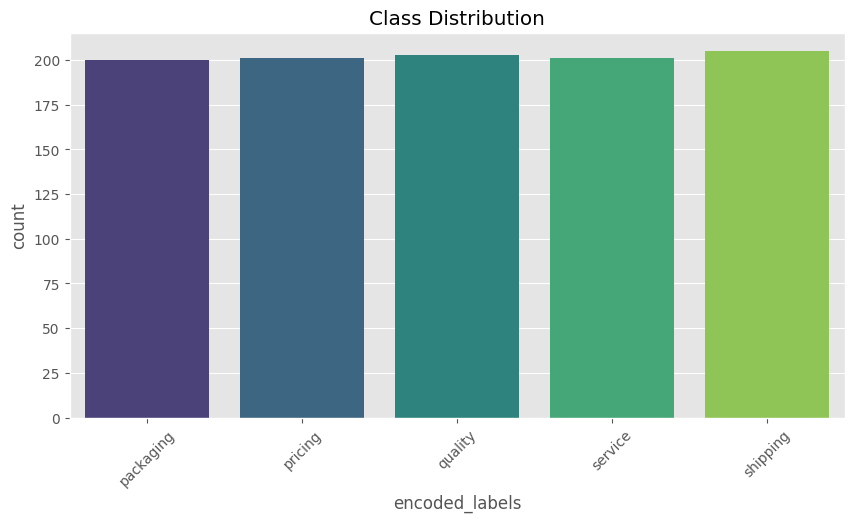

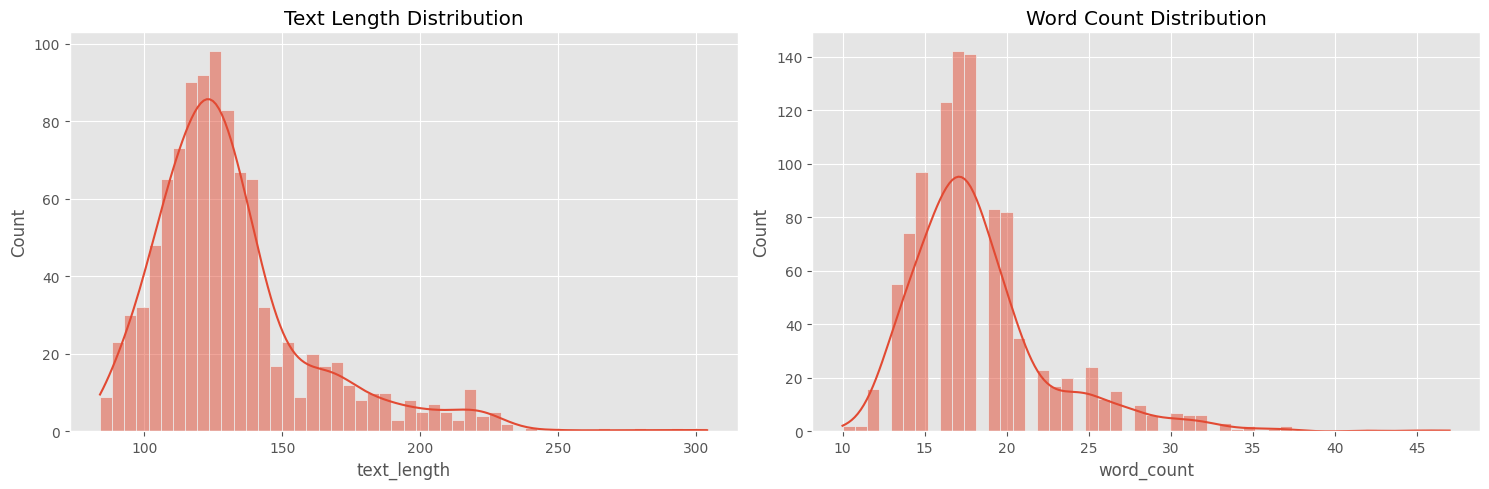

In [ ]:
def show_eda(df, class_names, text_col):
    """
    Perform Exploratory Data Analysis and visualize dataset characteristics

    Args:
        df (pd.DataFrame): Input DataFrame
        class_names (list): Names of target classes
        text_col (str): Name of text column
    """
    # Plot class distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df['encoded_labels'], palette='viridis')
    plt.title("Class Distribution")
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
    plt.show()

    # Add text length and word count features
    df['text_length'] = df[text_col].apply(len)
    df['word_count'] = df[text_col].apply(lambda x: len(x.split()))

    # Plot text length and word count distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df['text_length'], bins=50, ax=ax1, kde=True)
    ax1.set_title("Text Length Distribution")
    sns.histplot(df['word_count'], bins=50, ax=ax2, kde=True)
    ax2.set_title("Word Count Distribution")
    plt.tight_layout()
    plt.show()

# Example usage
show_eda(df, class_names, text_col)

## **Section 5: Text Preprocessing**

In [ ]:
def preprocess_text(text, dataset_type):
    """
    Preprocess text by cleaning, lemmatizing, and removing stopwords

    Args:
        text (str): Input text
        dataset_type (str): Type of dataset (amazon or imdb)

    Returns:
        str: Preprocessed text
    """
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Use spaCy for advanced text processing
    doc = nlp(text.lower())

    # Lemmatization and stopword removal
    lemmas = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and token.is_alpha and len(token.lemma_) > 2
    ]

    # Additional feature extraction for amazon dataset
    if dataset_type == 'amazon':
        lemmas += [
            token.text.lower()
            for token in doc
            if token.pos_ in ['ADJ', 'ADV'] and len(token.text) > 2
        ]

    return ' '.join(lemmas)

# Example usage
sample_text = "This is an amazing product with great quality!"
cleaned_text = preprocess_text(sample_text, 'amazon')
print("Original Text:", sample_text)
print("Cleaned Text:", cleaned_text)

Original Text: This is an amazing product with great quality!
Cleaned Text: amazing product great quality amazing great


## **Section 6: Feature Generation**

In [ ]:
def generate_features(df, dataset_type):
    """
    Generate various NLP and machine learning features

    Args:
        df (pd.DataFrame): Input DataFrame
        dataset_type (str): Type of dataset

    Returns:
        dict: Dictionary of generated features and vectorizers
    """
    df = df.reset_index(drop=True)

    # Basic text features
    df['char_count'] = df['cleaned_text'].apply(len)
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['cleaned_text'].apply(
        lambda x: np.mean([len(word) for word in x.split()]))

    # Additional aspect features for amazon dataset
    if dataset_type == 'amazon':
        aspects = {
            'packaging': ['package', 'wrap', 'box'],
            'pricing': ['price', 'cost', 'value'],
            'quality': ['quality', 'material', 'durable'],
            'service': ['service', 'support', 'staff'],
            'shipping': ['shipping', 'delivery', 'tracking']
        }
        for aspect, keywords in aspects.items():
            df[f'count_{aspect}'] = df['cleaned_text'].apply(
                lambda x: sum(1 for word in x.split() if word in keywords))

    # TF-IDF and Bag of Words vectorization
    tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
    X_tfidf = tfidf.fit_transform(df['cleaned_text'])

    bow = CountVectorizer(max_features=2000)
    X_bow = bow.fit_transform(df['cleaned_text'])

    # NLP feature matrix
    nlp_features = csr_matrix(df.filter(regex='count_|char|word|avg').values)

    return {
        'tfidf': tfidf,
        'bow': bow,
        'X_tfidf': X_tfidf,
        'X_bow': X_bow,
        'nlp_features': nlp_features
    }

## **Section 7: Model Validation**

In [ ]:
def validate_model(model, X, y, dataset_type, n_splits=5):
    """
    Validate model using stratified k-fold cross-validation

    Args:
        model: Machine learning model
        X: Feature matrix
        y: Target labels
        dataset_type: Type of dataset
        n_splits: Number of cross-validation splits

    Returns:
        dict: Validation metrics
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        if dataset_type == 'amazon':
            pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', model)])
        else:
            pipeline = model

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        accuracies.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))

    return {
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores)
    }

## **Section 8: Model Training and Evaluation**

In [ ]:
def train_and_evaluate(models, feature_sets, df, class_names, dataset_type):
    """
    Train and evaluate multiple models on different feature sets

    Args:
        models: Dictionary of models to train
        feature_sets: Dictionary of feature sets
        df: Input DataFrame
        class_names: List of class names
        dataset_type: Type of dataset

    Returns:
        tuple: Results DataFrame and list of trained models
    """
    results = []
    trained_models = []

    for model_name, model in models.items():
        for feature_name, feature_data in feature_sets.items():
            current_model = clone(model)
            X = feature_data
            y = df['encoded_labels'].values

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, stratify=y, random_state=42)

            val_results = validate_model(current_model, X_train, y_train, dataset_type)

            if dataset_type == 'amazon':
                smote = SMOTE(random_state=42)
                X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
                current_model.fit(X_train_res, y_train_res)
            else:
                current_model.fit(X_train, y_train)

            y_pred = current_model.predict(X_test)

            results.append({
                'model': model_name,
                'features': feature_name,
                'val_accuracy': val_results['mean_accuracy'],
                'val_f1': val_results['mean_f1'],
                'test_accuracy': accuracy_score(y_test, y_pred),
                'test_f1': f1_score(y_test, y_pred, average='weighted')
            })

            trained_models.append({
                'name': model_name,
                'model': current_model,
                'feature_name': feature_name
            })

    return results, trained_models

## **Section 9: Interactive Validation**

In [ ]:
def interactive_validation(trained_models, feature_objects, le, class_names, dataset_type):
    """
    Provide interactive text classification with multiple models

    Args:
        trained_models: List of trained models
        feature_objects: Dictionary of feature vectorizers
        le: Label encoder
        class_names: List of class names
        dataset_type: Type of dataset
    """
    while True:
        print("\n" + "="*60)
        text = input("Enter your text for classification (or 'exit' to quit): ")
        if text.lower() == 'exit':
            break

        cleaned_text = preprocess_text(text, dataset_type)
        temp_df = pd.DataFrame({'cleaned_text': [cleaned_text]})

        # Generate features
        temp_df['char_count'] = temp_df['cleaned_text'].apply(len)
        temp_df['word_count'] = temp_df['cleaned_text'].apply(lambda x: len(x.split()))
        temp_df['avg_word_length'] = temp_df['cleaned_text'].apply(
            lambda x: np.mean([len(word) for word in x.split()]))

        if dataset_type == 'amazon':
            aspects = {
                'packaging': ['package', 'wrap', 'box'],
                'pricing': ['price', 'cost', 'value'],
                'quality': ['quality', 'material', 'durable'],
                'service': ['service', 'support', 'staff'],
                'shipping': ['shipping', 'delivery', 'tracking']
            }
            for aspect, keywords in aspects.items():
                temp_df[f'count_{aspect}'] = temp_df['cleaned_text'].apply(
                    lambda x: sum(1 for word in x.split() if word in keywords))

        # Create feature matrices
        features = {
            'TF-IDF': feature_objects['tfidf'].transform(temp_df['cleaned_text']),
            'BoW': feature_objects['bow'].transform(temp_df['cleaned_text']),
            'NLP Features': csr_matrix(temp_df.filter(regex='count_|char|word|avg').values),
            'Combined': hstack([
                csr_matrix(temp_df.filter(regex='count_|char|word|avg').values),
                feature_objects['tfidf'].transform(temp_df['cleaned_text'])
            ])
        }

        predictions = []
        for model_info in trained_models:
            model = model_info['model']
            feature_name = model_info['feature_name']
            X = features[feature_name]

            try:
                pred = model.predict(X)
                proba = model.predict_proba(X)[0] if hasattr(model, 'predict_proba') else [1.0]
                confidence = f"{max(proba)*100:.1f}%"
            except:
                pred = [0]
                confidence = "N/A"

            predictions.append({
                'Model': model_info['name'],
                'Features': feature_name,
                'Prediction': class_names[pred[0]],
                'Confidence': confidence
            })

        print(f"\nOriginal Text: {text}")
        print(f"Cleaned Text: {cleaned_text}")
        display(pd.DataFrame(predictions))

## **Section 10: Main Execution**


########################################
Processing AMAZON dataset
########################################



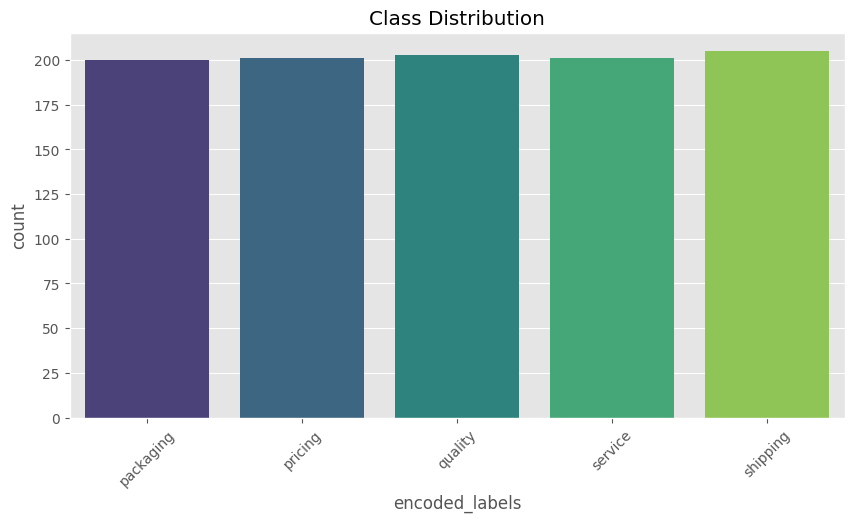

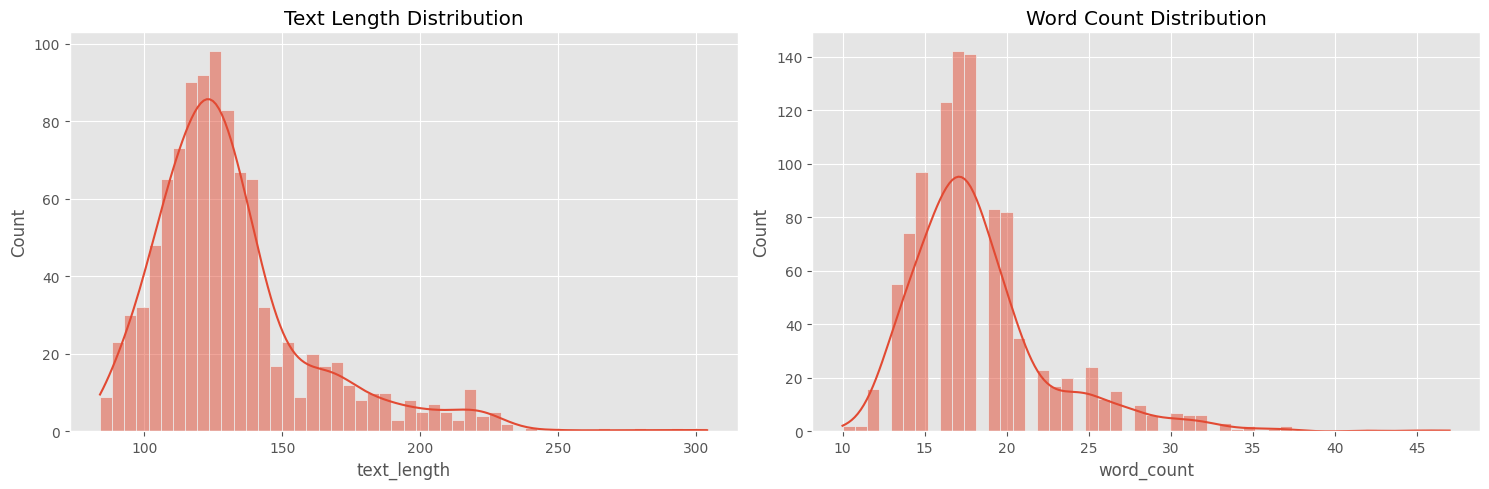


=== Training Results ===


,model,features,val_accuracy,val_f1,test_accuracy,test_f1
4,Logistic Regression,TF-IDF,0.940587,0.940689,0.970297,0.970284
5,Logistic Regression,BoW,0.941830,0.941869,0.960396,0.960492
13,Naive Bayes,BoW,0.928211,0.928539,0.955446,0.955837
9,Random Forest,BoW,0.914623,0.914479,0.950495,0.950513
12,Naive Bayes,TF-IDF,0.933165,0.933482,0.950495,0.950540
8,Random Forest,TF-IDF,0.908458,0.909072,0.935644,0.935363
1,XGBoost,BoW,0.914608,0.914755,0.915842,0.915924
0,XGBoost,TF-IDF,0.900997,0.901400,0.910891,0.910747
11,Random Forest,Combined,0.904716,0.905050,0.905941,0.905338
15,Naive Bayes,Combined,0.863921,0.865660,0.891089,0.890427



Starting Interactive Validation

Enter your text for classification (or 'exit' to quit): "The delivery was quick and tracking updates were timely."

Original Text: "The delivery was quick and tracking updates were timely."
Cleaned Text: delivery quick tracking update timely quick timely


,Model,Features,Prediction,Confidence
0,XGBoost,TF-IDF,shipping,92.4%
1,XGBoost,BoW,shipping,93.6%
2,XGBoost,NLP Features,shipping,99.1%
3,XGBoost,Combined,shipping,98.7%
4,Logistic Regression,TF-IDF,shipping,43.7%
5,Logistic Regression,BoW,shipping,46.6%
6,Logistic Regression,NLP Features,shipping,80.7%
7,Logistic Regression,Combined,shipping,83.2%
8,Random Forest,TF-IDF,shipping,62.0%
9,Random Forest,BoW,shipping,58.0%



Enter your text for classification (or 'exit' to quit): "The price of this product is too high considering its quality."

Original Text: "The price of this product is too high considering its quality."
Cleaned Text: price product high consider quality too high


,Model,Features,Prediction,Confidence
0,XGBoost,TF-IDF,pricing,67.2%
1,XGBoost,BoW,pricing,94.2%
2,XGBoost,NLP Features,pricing,43.3%
3,XGBoost,Combined,pricing,83.8%
4,Logistic Regression,TF-IDF,pricing,40.1%
5,Logistic Regression,BoW,pricing,47.2%
6,Logistic Regression,NLP Features,packaging,91.2%
7,Logistic Regression,Combined,packaging,89.5%
8,Random Forest,TF-IDF,pricing,56.0%
9,Random Forest,BoW,pricing,64.0%



Enter your text for classification (or 'exit' to quit): exit

########################################
Processing IMDB dataset
########################################



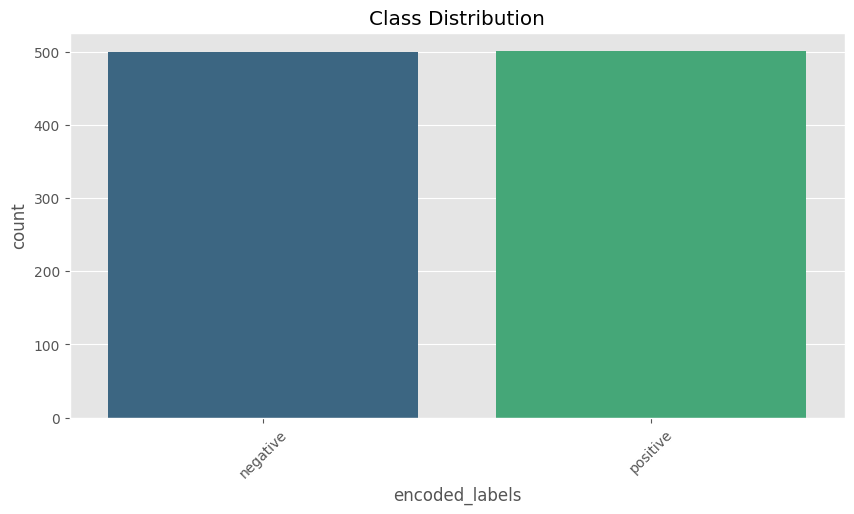

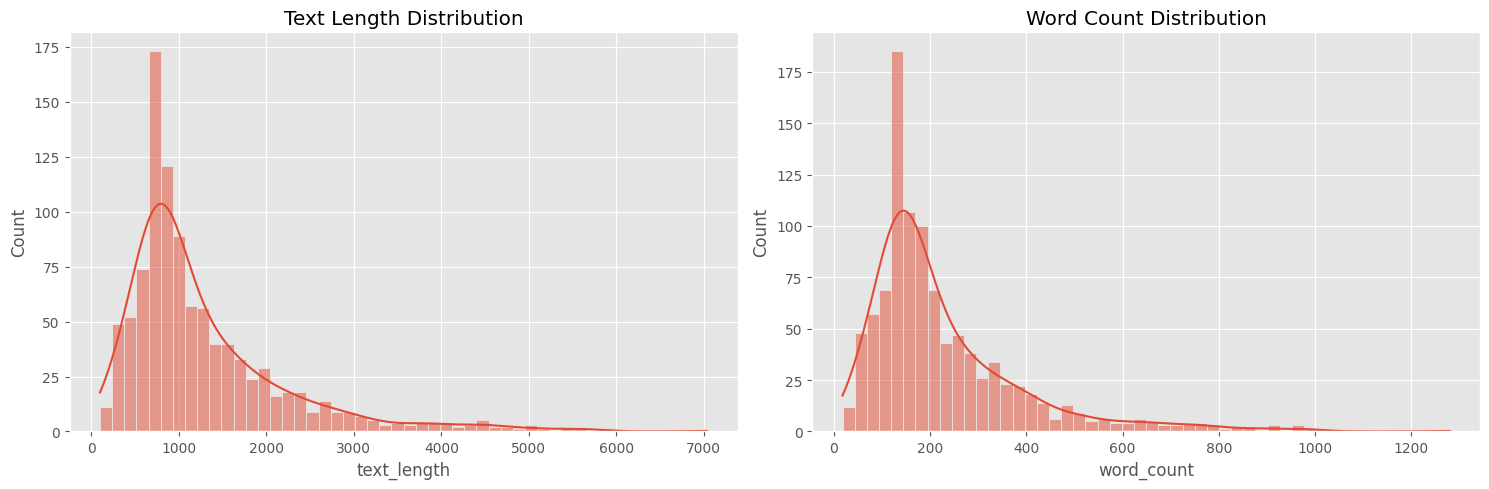


=== Training Results ===


,model,features,val_accuracy,val_f1,test_accuracy,test_f1
4,Logistic Regression,TF-IDF,0.81500,0.814744,0.825,0.824961
13,Naive Bayes,BoW,0.77875,0.778529,0.820,0.819838
12,Naive Bayes,TF-IDF,0.79375,0.793459,0.815,0.814773
9,Random Forest,BoW,0.79000,0.789671,0.795,0.794954
5,Logistic Regression,BoW,0.79250,0.792390,0.790,0.790000
8,Random Forest,TF-IDF,0.78875,0.788668,0.780,0.779802
1,XGBoost,BoW,0.77875,0.778524,0.755,0.754257
11,Random Forest,Combined,0.80875,0.808619,0.755,0.754700
15,Naive Bayes,Combined,0.69000,0.687407,0.735,0.733876
0,XGBoost,TF-IDF,0.76500,0.764855,0.695,0.694809



Starting Interactive Validation

Enter your text for classification (or 'exit' to quit): "The movie had great cinematography but poor storyline.",

Original Text: "The movie had great cinematography but poor storyline.",
Cleaned Text: movie great cinematography poor storyline


,Model,Features,Prediction,Confidence
0,XGBoost,TF-IDF,positive,86.3%
1,XGBoost,BoW,positive,68.2%
2,XGBoost,NLP Features,positive,84.7%
3,XGBoost,Combined,positive,91.1%
4,Logistic Regression,TF-IDF,positive,58.6%
5,Logistic Regression,BoW,negative,50.3%
6,Logistic Regression,NLP Features,negative,79.9%
7,Logistic Regression,Combined,negative,79.9%
8,Random Forest,TF-IDF,positive,76.0%
9,Random Forest,BoW,positive,64.0%



Enter your text for classification (or 'exit' to quit): "I absolutely loved the acting and the direction was phenomenal!"

Original Text: "I absolutely loved the acting and the direction was phenomenal!"
Cleaned Text: absolutely love acting direction phenomenal


,Model,Features,Prediction,Confidence
0,XGBoost,TF-IDF,positive,95.7%
1,XGBoost,BoW,positive,85.1%
2,XGBoost,NLP Features,positive,73.4%
3,XGBoost,Combined,positive,96.4%
4,Logistic Regression,TF-IDF,positive,69.5%
5,Logistic Regression,BoW,positive,77.5%
6,Logistic Regression,NLP Features,negative,81.0%
7,Logistic Regression,Combined,negative,81.0%
8,Random Forest,TF-IDF,positive,84.0%
9,Random Forest,BoW,positive,71.0%



Enter your text for classification (or 'exit' to quit): exit

All models processed successfully! Label encoder saved.


In [ ]:
# Main execution
for dataset_name, path in DATASETS.items():
    print(f"\n{'#'*40}")
    print(f"Processing {dataset_name.upper()} dataset")
    print(f"{'#'*40}\n")

    df, class_names, dataset_type, text_col, target_col, le = load_data(path)
    df['cleaned_text'] = df[text_col].apply(lambda x: preprocess_text(x, dataset_type))

    show_eda(df, class_names, text_col)
    features = generate_features(df, dataset_type)

    feature_sets = {
        'TF-IDF': features['X_tfidf'],
        'BoW': features['X_bow'],
        'NLP Features': features['nlp_features'],
        'Combined': hstack([features['nlp_features'], features['X_tfidf']])
    }

    models = {
        'XGBoost': XGBClassifier(eval_metric='logloss'),
        'Logistic Regression': LogisticRegression(max_iter=2000, solver='saga', penalty='l2'),
        'Random Forest': RandomForestClassifier(),
        'Naive Bayes': MultinomialNB()
    }

    results, trained_models = train_and_evaluate(models, feature_sets, df, class_names, dataset_type)
    results_df = pd.DataFrame(results)
    print("\n=== Training Results ===")
    display(results_df.sort_values(by='test_accuracy', ascending=False))

    feature_objects = {
        'tfidf': features['tfidf'],
        'bow': features['bow']
    }

    print("\n" + "="*60)
    print("Starting Interactive Validation")
    interactive_validation(trained_models, feature_objects, le, class_names, dataset_type)

# Save the label encoder
joblib.dump(le, 'label_encoder.pkl')
print("\nAll models processed successfully! Label encoder saved.")

## **Section 11: Matrix Visualization**

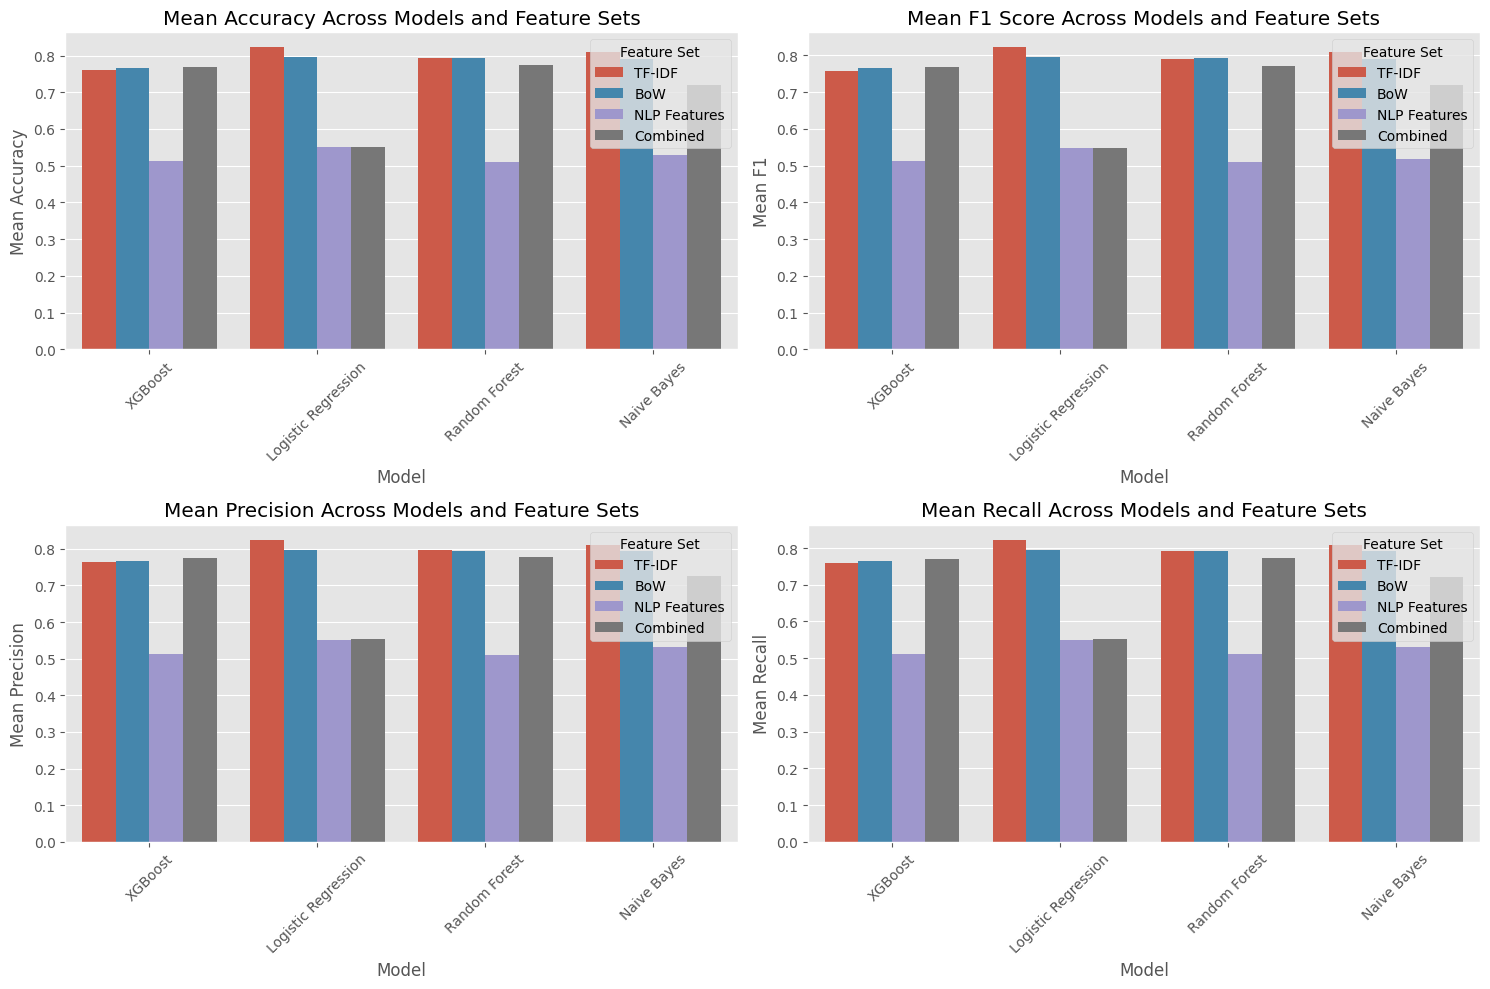

,Model,Feature Set,Mean Accuracy,Std Accuracy,Mean F1,Mean Precision,Mean Recall
4,Logistic Regression,TF-IDF,0.822,0.032802,0.821640,0.824264,0.822
12,Naive Bayes,TF-IDF,0.809,0.022000,0.808758,0.810466,0.809
5,Logistic Regression,BoW,0.795,0.020248,0.794583,0.797174,0.795
9,Random Forest,BoW,0.793,0.032031,0.792575,0.795028,0.793
8,Random Forest,TF-IDF,0.792,0.045563,0.791002,0.796123,0.792
13,Naive Bayes,BoW,0.791,0.025573,0.790540,0.793160,0.791
11,Random Forest,Combined,0.773,0.033556,0.772043,0.776787,0.773
3,XGBoost,Combined,0.770,0.032094,0.768984,0.773812,0.770
1,XGBoost,BoW,0.765,0.015166,0.764524,0.766833,0.765
0,XGBoost,TF-IDF,0.760,0.027749,0.758605,0.764685,0.760



Detailed Per-Class Performance:

XGBoost Performance:

  Feature Set: TF-IDF
    Per-Class Metrics (Mean ± Std):
    negative:
      Precision: 0.772 ± 0.039
      Recall:    0.743 ± 0.078
      F1-Score:  0.754 ± 0.038
      Support:   100
    positive:
      Precision: 0.757 ± 0.041
      Recall:    0.776 ± 0.071
      F1-Score:  0.763 ± 0.032
      Support:   100

  Feature Set: BoW
    Per-Class Metrics (Mean ± Std):
    negative:
      Precision: 0.763 ± 0.026
      Recall:    0.771 ± 0.046
      F1-Score:  0.766 ± 0.019
      Support:   100
    positive:
      Precision: 0.771 ± 0.025
      Recall:    0.758 ± 0.045
      F1-Score:  0.763 ± 0.019
      Support:   100

  Feature Set: NLP Features
    Per-Class Metrics (Mean ± Std):
    negative:
      Precision: 0.511 ± 0.024
      Recall:    0.521 ± 0.030
      F1-Score:  0.516 ± 0.026
      Support:   100
    positive:
      Precision: 0.513 ± 0.027
      Recall:    0.503 ± 0.029
      F1-Score:  0.508 ± 0.027
      Support:   1

In [ ]:
def comprehensive_model_validation(models, feature_sets, df, class_names, dataset_type):
    """
    Perform comprehensive model validation with detailed metrics

    Args:
        models: Dictionary of models to validate
        feature_sets: Dictionary of feature sets
        df: Input DataFrame
        class_names: List of class names
        dataset_type: Type of dataset

    Returns:
        dict: Detailed validation results for each model and feature set
    """
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import (
        accuracy_score,
        f1_score,
        precision_score,
        recall_score,
        classification_report
    )
    from imblearn.over_sampling import SMOTE
    from sklearn.base import clone

    detailed_results = {}

    for model_name, model in models.items():
        detailed_results[model_name] = {}

        for feature_name, feature_data in feature_sets.items():
            # Clone the model to avoid modifying the original
            current_model = clone(model)
            X = feature_data
            y = df['encoded_labels'].values

            # Stratified cross-validation
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            # Metrics to track
            cv_accuracies = []
            cv_f1_scores = []
            cv_precision_scores = []
            cv_recall_scores = []

            # Detailed fold-wise results
            fold_results = []

            for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                # Handle class imbalance for Amazon dataset
                if dataset_type == 'amazon':
                    smote = SMOTE(random_state=42)
                    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
                    current_model.fit(X_train_res, y_train_res)
                else:
                    current_model.fit(X_train, y_train)

                # Predictions
                y_pred = current_model.predict(X_val)

                # Compute metrics
                accuracy = accuracy_score(y_val, y_pred)
                f1 = f1_score(y_val, y_pred, average='weighted')

                # Use multi-class strategies for precision and recall
                precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)

                # Store metrics
                cv_accuracies.append(accuracy)
                cv_f1_scores.append(f1)
                cv_precision_scores.append(precision)
                cv_recall_scores.append(recall)

                # Detailed classification report for each fold
                report = classification_report(y_val, y_pred, target_names=class_names, output_dict=True)

                fold_results.append({
                    'fold': fold,
                    'accuracy': accuracy,
                    'f1_score': f1,
                    'precision': precision,
                    'recall': recall,
                    'classification_report': report
                })

            # Aggregate results
            detailed_results[model_name][feature_name] = {
                'mean_accuracy': np.mean(cv_accuracies),
                'std_accuracy': np.std(cv_accuracies),
                'mean_f1': np.mean(cv_f1_scores),
                'std_f1': np.std(cv_f1_scores),
                'mean_precision': np.mean(cv_precision_scores),
                'std_precision': np.std(cv_precision_scores),
                'mean_recall': np.mean(cv_recall_scores),
                'std_recall': np.std(cv_recall_scores),
                'fold_results': fold_results
            }

    return detailed_results

def visualize_validation_results(validation_results, class_names):
    """
    Visualize comprehensive validation results

    Args:
        validation_results: Dictionary of validation results
        class_names: List of class names
    """
    # Create summary DataFrame
    summary_data = []
    for model, features in validation_results.items():
        for feature_set, metrics in features.items():
            summary_data.append({
                'Model': model,
                'Feature Set': feature_set,
                'Mean Accuracy': metrics['mean_accuracy'],
                'Std Accuracy': metrics['std_accuracy'],
                'Mean F1': metrics['mean_f1'],
                'Mean Precision': metrics['mean_precision'],
                'Mean Recall': metrics['mean_recall']
            })

    summary_df = pd.DataFrame(summary_data)

    # Plotting
    plt.figure(figsize=(15, 10))

    # Accuracy comparison
    plt.subplot(2, 2, 1)
    sns.barplot(x='Model', y='Mean Accuracy', hue='Feature Set', data=summary_df)
    plt.title('Mean Accuracy Across Models and Feature Sets')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # F1 Score comparison
    plt.subplot(2, 2, 2)
    sns.barplot(x='Model', y='Mean F1', hue='Feature Set', data=summary_df)
    plt.title('Mean F1 Score Across Models and Feature Sets')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Precision comparison
    plt.subplot(2, 2, 3)
    sns.barplot(x='Model', y='Mean Precision', hue='Feature Set', data=summary_df)
    plt.title('Mean Precision Across Models and Feature Sets')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Recall comparison
    plt.subplot(2, 2, 4)
    sns.barplot(x='Model', y='Mean Recall', hue='Feature Set', data=summary_df)
    plt.title('Mean Recall Across Models and Feature Sets')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

    # Display summary DataFrame
    display(summary_df.sort_values('Mean Accuracy', ascending=False))

    # Detailed per-class performance
    print("\nDetailed Per-Class Performance:")
    for model, features in validation_results.items():
        print(f"\n{model} Performance:")
        for feature_set, metrics in features.items():
            print(f"\n  Feature Set: {feature_set}")

            # Average classification report across folds
            avg_reports = {}
            for fold_result in metrics['fold_results']:
                for cls in class_names:
                    if cls not in avg_reports:
                        avg_reports[cls] = {
                            'precision': [],
                            'recall': [],
                            'f1-score': [],
                            'support': []
                        }

                    fold_report = fold_result['classification_report']
                    avg_reports[cls]['precision'].append(fold_report[cls]['precision'])
                    avg_reports[cls]['recall'].append(fold_report[cls]['recall'])
                    avg_reports[cls]['f1-score'].append(fold_report[cls]['f1-score'])
                    avg_reports[cls]['support'].append(fold_report[cls]['support'])

            # Compute averages
            print("    Per-Class Metrics (Mean ± Std):")
            for cls in class_names:
                print(f"    {cls}:")
                print(f"      Precision: {np.mean(avg_reports[cls]['precision']):.3f} ± {np.std(avg_reports[cls]['precision']):.3f}")
                print(f"      Recall:    {np.mean(avg_reports[cls]['recall']):.3f} ± {np.std(avg_reports[cls]['recall']):.3f}")
                print(f"      F1-Score:  {np.mean(avg_reports[cls]['f1-score']):.3f} ± {np.std(avg_reports[cls]['f1-score']):.3f}")
                print(f"      Support:   {np.mean(avg_reports[cls]['support']):.0f}")

# Add this to the main execution block after train_and_evaluate
validation_results = comprehensive_model_validation(models, feature_sets, df, class_names, dataset_type)
visualize_validation_results(validation_results, class_names)